In [3]:
import quandl as qn
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from sliding_window import sliding_window  ## Defined functions ## 
from AutoEncoder import AutoEncoder
from AutoEncoderMLP import AutoEncoderMLP
from outliers import outliers 
import warnings
warnings.filterwarnings("ignore")

qn.ApiConfig.api_key = "HQV7bdPFvAn1QUxxkN5c"
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
Data=[]
Companies=["EOD/GOOGL"]#,"EOD/FB","EOD/AAPL","EOD/AMZN"]#,"EOD/MSFT"]
InitDate="2012-05-20"
EndDate="2017-12-01"
for company in Companies:
    data=qn.get(company, start_date=InitDate, end_date=EndDate,collapse="daily", transformation='rdiff')
    Data.append(data['Close'])

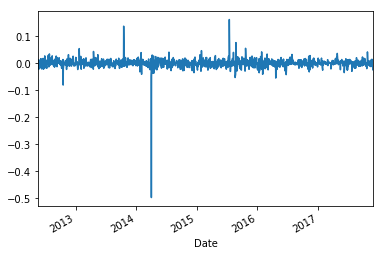

In [5]:
# We make decision to measure sigma and cut the outliers based upon of sigmas # 
Outliers=[]
Data_NO=copy.deepcopy(Data) ## Without outliers ## Data_NO
Data[0].plot()
plt.show()

Original Data:
std: 0.019213 
mean: 0.000599 


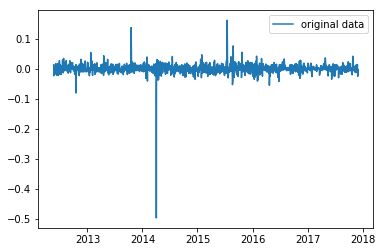

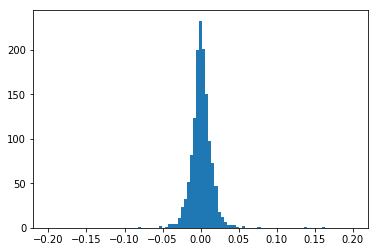

End of original data and start cutting outliers with respect to distribution 
 ############# 

std without outliers  : 0.019213 
mean without outliers : 0.000599 
(104, -0.080067241128274)
(167, 0.054960376741075997)
(354, 0.13795772698736)
(468, -0.49652013038498999)
(792, 0.16258433314500001)
(817, -0.052172249367162998)
(820, 0.077179290414224)
(861, 0.056067768740640997)
(985, -0.054141025641025999)


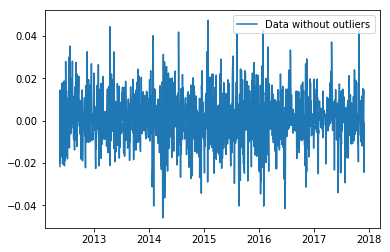

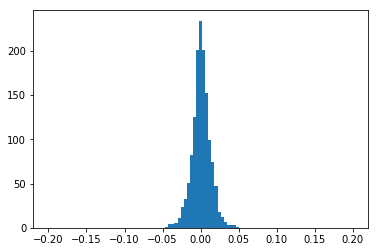

End of removing outliers from data and start scaling the data with no outliers 
 ############# 

std of scaled : 0.252715 
mean of scaled: 0.015208 


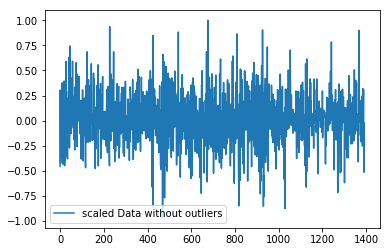

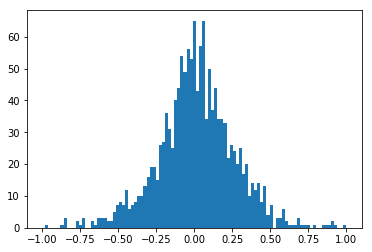

In [6]:
'''
Data[0].plot()    
Data_NO[0].plot()
sData[0].plot()
plt.show()    
plt.clf()
plt.hist(Data[0])
plt.show()
plt.clf()
plt.hist(Data_NO[0])
plt.show()
'''

bins = np.linspace(-0.2, 0.2, 100)
print("Original Data:")
print("std: %f " %np.std(Data[0]))
print("mean: %f " %np.mean(Data[0]))
plt.clf()
a1=plt.plot(Data[0],label="original data")
plt.legend(handles=a1)
plt.show()

plt.clf()
plt.hist(Data[0],bins)
plt.show()


print("End of original data and start cutting outliers with respect to distribution \n ############# \n")


print("std without outliers  : %f " %np.std(Data_NO[0]))
print("mean without outliers : %f " %np.mean(Data_NO[0]))

plt.clf()
outliers(Data_NO,-0.05,0.05)
a1=plt.plot(Data_NO[0],label="Data without outliers")
plt.legend(handles=a1)
plt.show()

plt.clf()
plt.hist(Data_NO[0],bins)
plt.show()


#plt.clf()
#Data_NO[0].plot()
#plt.show()

print("End of removing outliers from data and start scaling the data with no outliers \n ############# \n")


#sData.append(max_abs_scaler.fit_transform(Data_NO[0])
#scaler = MinMaxScaler()
#serries_scaled=[]
max_abs_scaler = preprocessing.MaxAbsScaler()
sData=[]
for i in range(len(Data_NO)):
    data=pd.DataFrame(max_abs_scaler.fit_transform(Data_NO[0]))         
#    data=pd.DataFrame(scaler.fit_transform(Data_NO[i]))#, columns=Data_NO[i].columns)
    sData.append(data)



print("std of scaled : %f " %np.std(sData[0]))
print("mean of scaled: %f " %np.mean(sData[0]))

#np.mean(Data_NO[0])*len()

sbins = np.linspace(-1.0, 1.0, 100)

plt.clf()
#outliers(Data_,-0.05,0.05)
a1=plt.plot(sData[0],label="scaled Data without outliers")
plt.legend(handles=a1)
plt.show()

plt.clf()
plt.hist(sData[0],sbins)
plt.show()


#print np.mean(Data[0])
#df_sGoogle = pd.DataFrame(scaler.fit_transform(df_google), columns=df_google.columns)
#df_sFb = pd.DataFrame(scaler.fit_transform(df_fb), columns=df_fb.columns)
#df_sApple = pd.DataFrame(scaler.fit_transform(df_apple), columns=df_apple.columns)
#df_sMic = pd.DataFrame(scaler.fit_transform(df_mic), columns=df_mic.columns)
#df_sAmz = pd.DataFrame(scaler.fit_transform(df_amz), columns=df_amz.columns)

In [7]:
combined=[]
for i in range(len(sData)):
    combined.append(np.column_stack((sData[i] for j in range(i+1)))) #,df_fb,df_apple, df_amz))#print combined
#combined=combined[:].ravel()
print combined[0].shape[:]# from http://www.johnvinyard.com/blog/?p=268
#print combined[3].shape[:]# from http://www.johnvinyard.com/blog/?p=268

(1393, 1)


In [8]:
# Sliding over time series # 
# Making Image data #
nDays=20   # time window each number of images
tDays=1374 # total number of days 
nCompanies=1

scan=(nDays,nCompanies)
#scan=(20,2)
stride=(1,0)
InputMatrices=[]
matrices=[]

for i in range(nCompanies):
    InputMatrices.append(sliding_window(combined[i],(nDays,i+1),stride))
    print InputMatrices[i].shape[:]
    matrices.append(InputMatrices[i].reshape(tDays,(i+1)*nDays))    

print InputMatrices[0].shape[:]
print matrices[0].shape[:]
#print InputMatrices[0]
#matrices.append(InputMatrices.reshape(,i*nDays))
#print matrices.shape[:]
#print matrices[0]

(1374, 20)
(1374, 20)
(1374, 20)


In [9]:
## Deviding the data into train, testing and validation ## 
train_size=int(tDays*0.5)
valid_size=int(tDays*0.25)
test_size=int(tDays*0.25)

train_matrices=matrices[0][0:train_size]
valid_matrices=matrices[0][train_size:train_size+valid_size]
test_matrices=matrices[0][train_size+valid_size:tDays]
#print train_matrices.shape[:]
#combinedTrain=[]
#for i in range(len(train_matrices)):
#    combinedTrain.append(np.column_stack((train_matrices[i]))) #,df_fb,df_apple, df_amz))#print combined
#combined=combined[:].ravel()
#print combined[0].shape[:]# from http://www.johnvinyard.com/blog/?p=268

## shuffling the training matrices ## 
#combinedTrain=train_matrices.reshape(train_size*nDays)
#np.random.shuffle(combinedTrain)
#train_matrices=combinedTrain.reshape(train_size, nDays)
#print train_matrices[0]



#print train_matrices.shape[:]
#print train_size
#print test_size
#print valid_size
#print train_size+2*test_size
#print len(train_matrices[0])
#print len(combinedTrain)
#print train_matrices[0]
#print combinedTrain

In [15]:
### We try to measure compressibility factor of each company and then companies combined together ### 
# In order to do so, we change the econded dimention #
# original dimention we choose is 20 days (20) # 

In [10]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs=1000
(autoencoder, encoder, decoder)=AutoEncoderMLP(1, nDays, [15,10,5])
print autoencoder.summary()
print encoder.summary()
print decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_5 (Dense)              (None, 15)                165       
_________________________________________________________________
dense_6 (Dense)              (None, 20)                320       
Total para

In [12]:
Path='saved_models/Ezzat/weights.best.google.'+'encDim'+'5_3Layers'+'.hdf5'
print Path
checkpoint=ModelCheckpoint(filepath=Path, 
                               verbose=1, save_best_only=True)
history=autoencoder.fit(train_matrices, train_matrices, validation_data=(valid_matrices, valid_matrices),
                epochs=epochs,
                batch_size=20,
                shuffle=True,  callbacks=[checkpoint], verbose=1,
                )


saved_models/Ezzat/weights.best.google.encDim5_3Layers.hdf5
Train on 687 samples, validate on 343 samples
Epoch 1/1000
687/687 [==============================] - 0s - loss: 0.0641 - val_loss: 0.0793
Epoch 2/1000
687/687 [==============================] - 0s - loss: 0.0629 - val_loss: 0.0778
Epoch 3/1000
687/687 [==============================] - 0s - loss: 0.0615 - val_loss: 0.0765
Epoch 4/1000
687/687 [==============================] - 0s - loss: 0.0603 - val_loss: 0.0753
Epoch 5/1000
687/687 [==============================] - 0s - loss: 0.0594 - val_loss: 0.0743
Epoch 6/1000
687/687 [==============================] - 0s - loss: 0.0587 - val_loss: 0.0735
Epoch 7/1000
687/687 [==============================] - 0s - loss: 0.0580 - val_loss: 0.0726
Epoch 8/1000
687/687 [==============================] - 0s - loss: 0.0573 - val_loss: 0.0716
Epoch 9/1000
687/687 [==============================] - 0s - loss: 0.0564 - val_loss: 0.0706
Epoch 10/1000
687/687 [==============================] - 

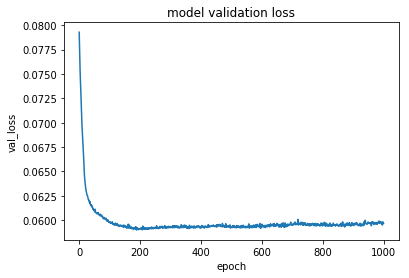

In [13]:
plt.clf()

# summarize history for loss
Label="MLP encoded Dimention="+str(5)
a1,=plt.plot(history.history['val_loss'],label=Label)
#plt.legend(handles=a1,)
#plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

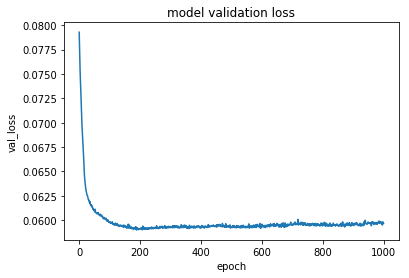

In [14]:
plt.clf()

# summarize history for loss
Label="MLP encoded Dimention="+str(5)
a1,=plt.plot(history.history['val_loss'],label=Label)
#plt.legend(handles=a1,)
#plt.plot(history.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


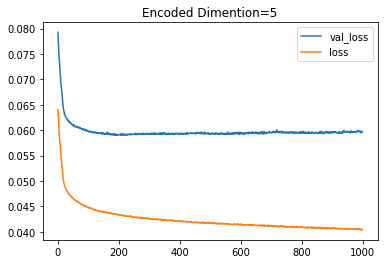

In [15]:
plt.clf()
a1,=plt.plot(history.history['val_loss'],label='val_loss')
a2,=plt.plot(history.history['loss'],label='loss') 
plt.title("Encoded Dimention="+"5")
plt.legend(handles=[a1,a2])
#    plt.legend(str(2+2*i)) #HillllO")    
plt.show()    


In [17]:
dec_imgs=[]
enc_imgs=[]
rec_imgs=[]
for i in range(nCompanies):
    dec_imgs.append(autoencoder.predict(test_matrices))
    enc_imgs.append(encoder.predict(test_matrices))
    rec_imgs.append(decoder.predict(enc_imgs))
print len(dec_imgs[0])
print len(enc_imgs[0])
print len(rec_imgs[0])
print len(train_matrices)

344
344
344
687


In [18]:
#nCompanies=4
#nImages=1142
print len(train_matrices)
print len(test_matrices)
print len(valid_matrices)
print len(dec_imgs[0])#.shape[:]
#print enc_imgs.shape[:]
#print matrices.shape[:]
def reconTSeries(Imgs, nImgs, nDays, cIndex):
    l1=[]
    for i in range(0,nImgs):
        for j in range(0,nDays):
            l1.append(Imgs[i][j*nCompanies+cIndex])
    return l1

def checkTSeries(Imgs, nImgs, nDays, cIndex):
    l1=[]
    for i in range(0,nImgs):
        for j in range(0,nDays):
            if Imgs[i][nDays*nCompanies+cIndex] > 0.5:
                l1.append(Imgs[i][j*nCompanies+cIndex])
    return l1
'''
plt.clf()

oTime=[]
f, axes = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(25,10))
print axes.shape[:]
oTime=reconTSeries(test_matrices, len(test_matrices), 20, 0)
timeSeries=pd.DataFrame(oTime)
axes[0].set_ylim(-1,1)
axes[0].plot(timeSeries)
oTime=reconTSeries(dec_imgs[i], len(dec_imgs[i]), 20, 0)
timeSeries=pd.DataFrame(oTime)
axes[1].set_ylim(-1,1)    
axes[1].plot(timeSeries)
plt.show()
'''

687
344
343
344


"\nplt.clf()\n\noTime=[]\nf, axes = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(25,10))\nprint axes.shape[:]\noTime=reconTSeries(test_matrices, len(test_matrices), 20, 0)\ntimeSeries=pd.DataFrame(oTime)\naxes[0].set_ylim(-1,1)\naxes[0].plot(timeSeries)\noTime=reconTSeries(dec_imgs[i], len(dec_imgs[i]), 20, 0)\ntimeSeries=pd.DataFrame(oTime)\naxes[1].set_ylim(-1,1)    \naxes[1].plot(timeSeries)\nplt.show()\n"

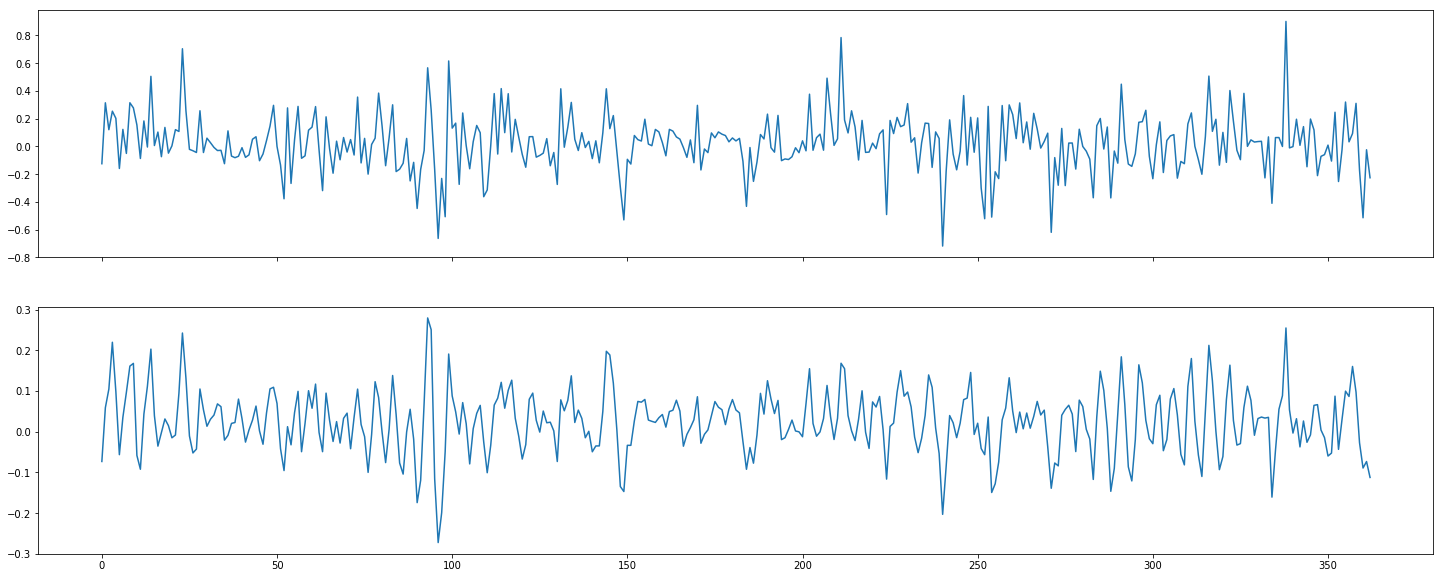

In [25]:
def overlapSeries(ovSeries, nDays):
    (x,y)=divmod(len(ovSeries)-1,nDays)
    n=x+y
    l1=[0]*(n+1)
    index=[0]*(n+1)
    for i in range(len(ovSeries)):
        (x,y)=divmod(i,nDays)
        l1[x+y]=l1[x+y]+ovSeries[i]
        index[x+y]=index[x+y]+1
    for i in range(len(l1)):
        l1[i]=l1[i]/index[i] 
    return l1


plt.clf()
f, axes = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(25,10))
for i in range(nCompanies):
    oTime=reconTSeries(test_matrices, len(test_matrices), 20, i)
    oTime=overlapSeries(oTime,20)    
    test_timeSeries=pd.DataFrame(oTime)
#    axes[0,i].set_ylim(0,1)
    axes[0].plot(timeSeries)
    oTime=reconTSeries(dec_imgs[0], len(dec_imgs[0]), 20, i)
    oTime=overlapSeries(oTime,20)        
    dec_test_timeSeries=pd.DataFrame(oTime)
#    axes[1,i].set_ylim(0,1)    
    axes[1].plot(timeSeries1)
plt.show()



In [55]:
#dumData=[]
#print test_timeSeries
dumData=pd.concat([test_timeSeries, dec_test_timeSeries], axis=1)
#dumData=[test_timeSeries, dec_test_timeSeries]
#dumData
#print dumData[0]
#np.matrix(dumData)
#Origin_Decod=pd.DataFrame(dumData,columns=['col1,col2'])
#Origin_Decod
dumData.columns = ['original', 'decoded']
dumData.corr()

,original,decoded
original,1.000000,0.766755
decoded,0.766755,1.000000


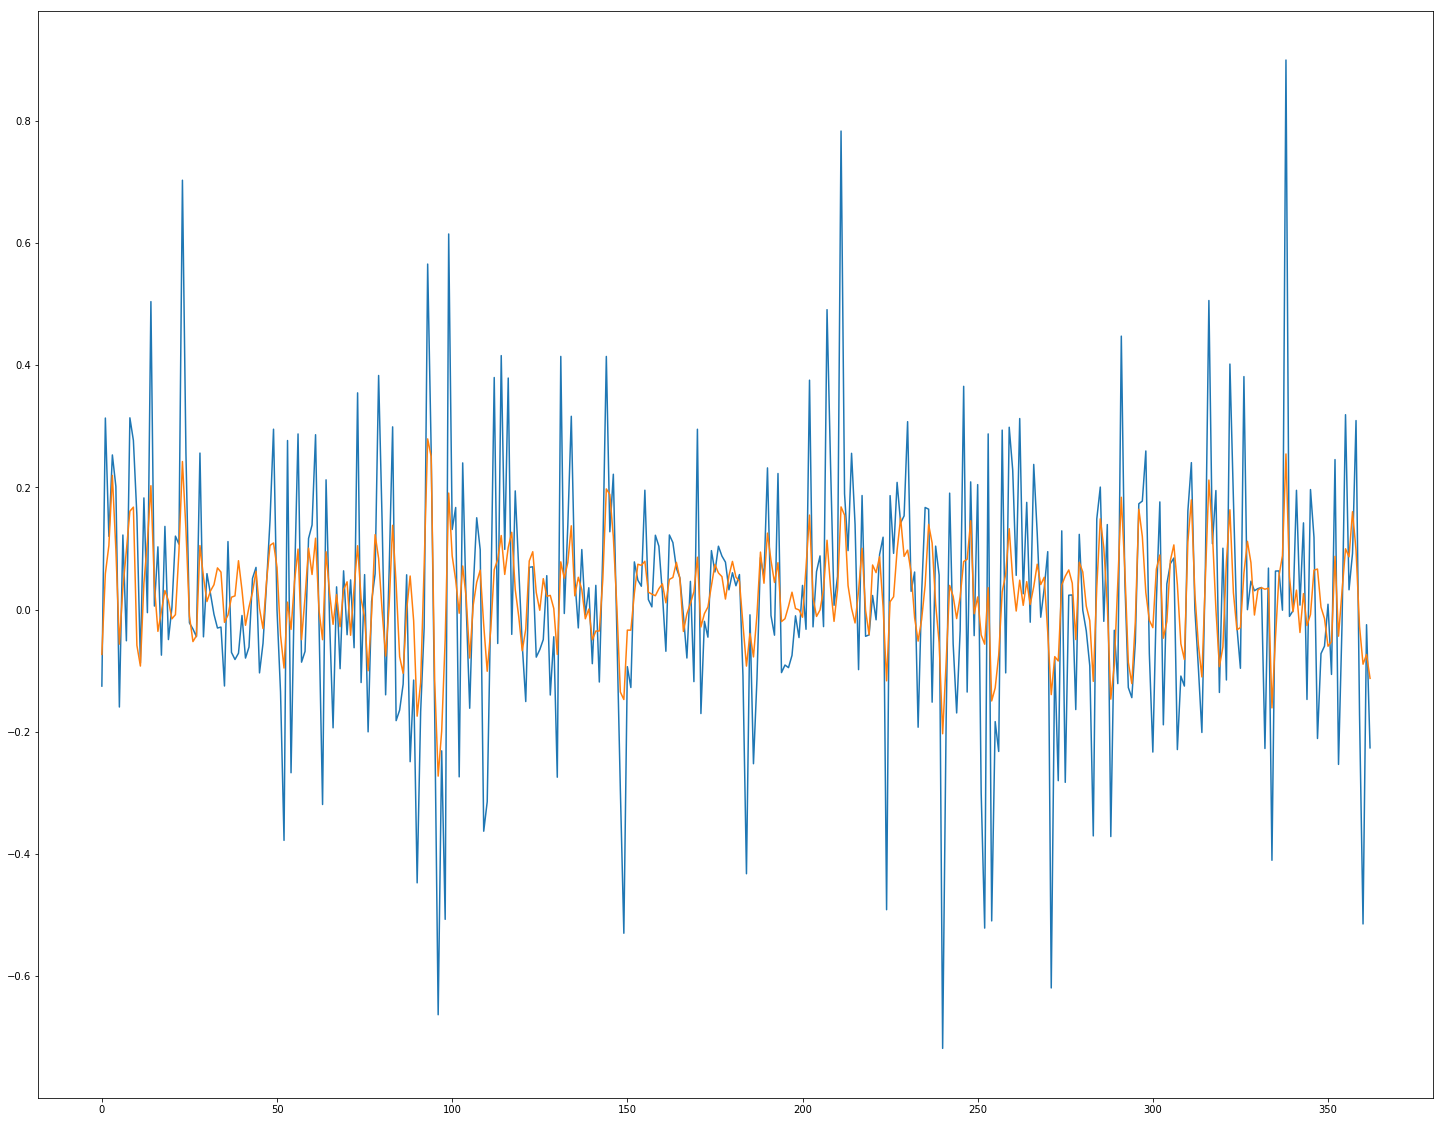

In [56]:
plt.clf()
plt.figure(figsize=(25,20))
plt.plot(test_timeSeries)
plt.plot(dec_test_timeSeries)
plt.show()

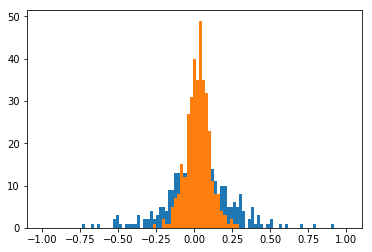

In [57]:
plt.clf()
plt.hist(test_timeSeries,sbins)
plt.hist(dec_test_timeSeries,sbins)
plt.show()

In [58]:
dec_imgs_train=[]
enc_imgs_train=[]
for i in range(nCompanies):
    dec_imgs_train.append(autoencoder.predict(train_matrices))
    enc_imgs_train.append(encoder.predict(train_matrices))
print len(dec_imgs_train[0])
print len(enc_imgs_train[0])
print len(train_matrices)

687
687
687


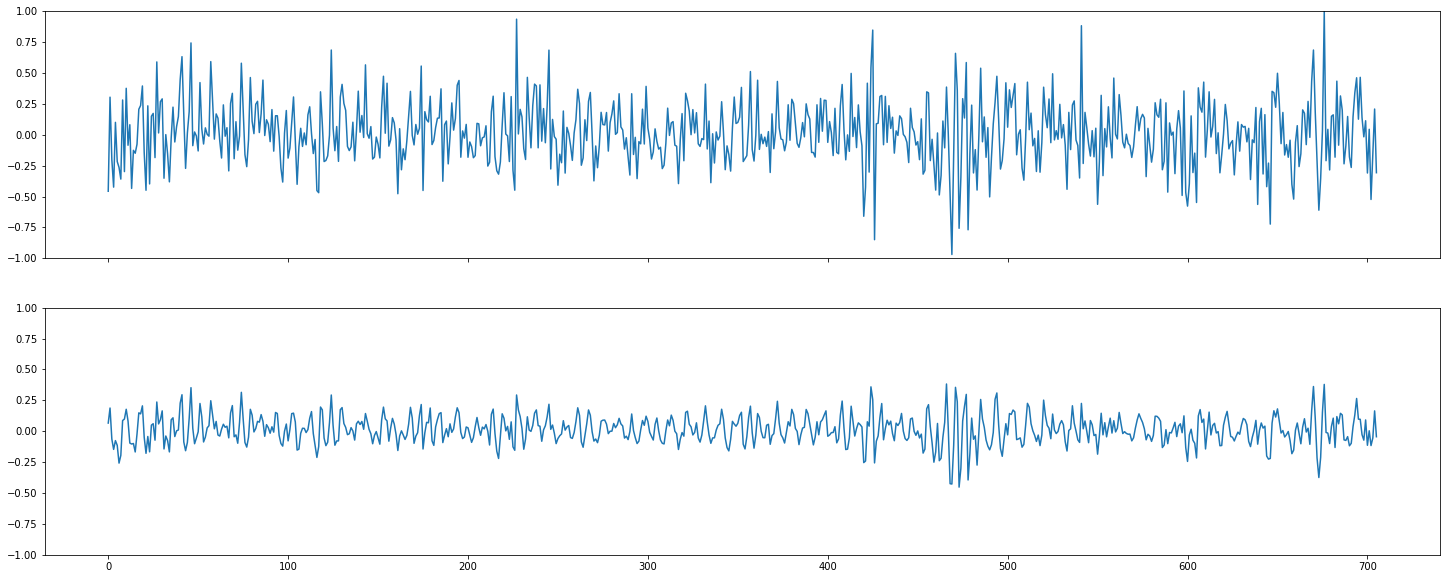

In [59]:
plt.clf()
f, axes = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(25,10))
for i in range(nCompanies):
    oTime=reconTSeries(train_matrices, len(train_matrices), 20, i)
    oTime=overlapSeries(oTime,20)    
    timeSeries_original=pd.DataFrame(oTime)
    axes[0].set_ylim(-1,1)
    axes[0].plot(timeSeries_original)
    oTime=reconTSeries(dec_imgs_train[0], len(dec_imgs_train[0]), 20, i)
    oTime=overlapSeries(oTime,20)        
    timeSeries_reconstructed=pd.DataFrame(oTime)
    axes[1].set_ylim(-1,1)    
    axes[1].plot(timeSeries_reconstructed)
plt.show()


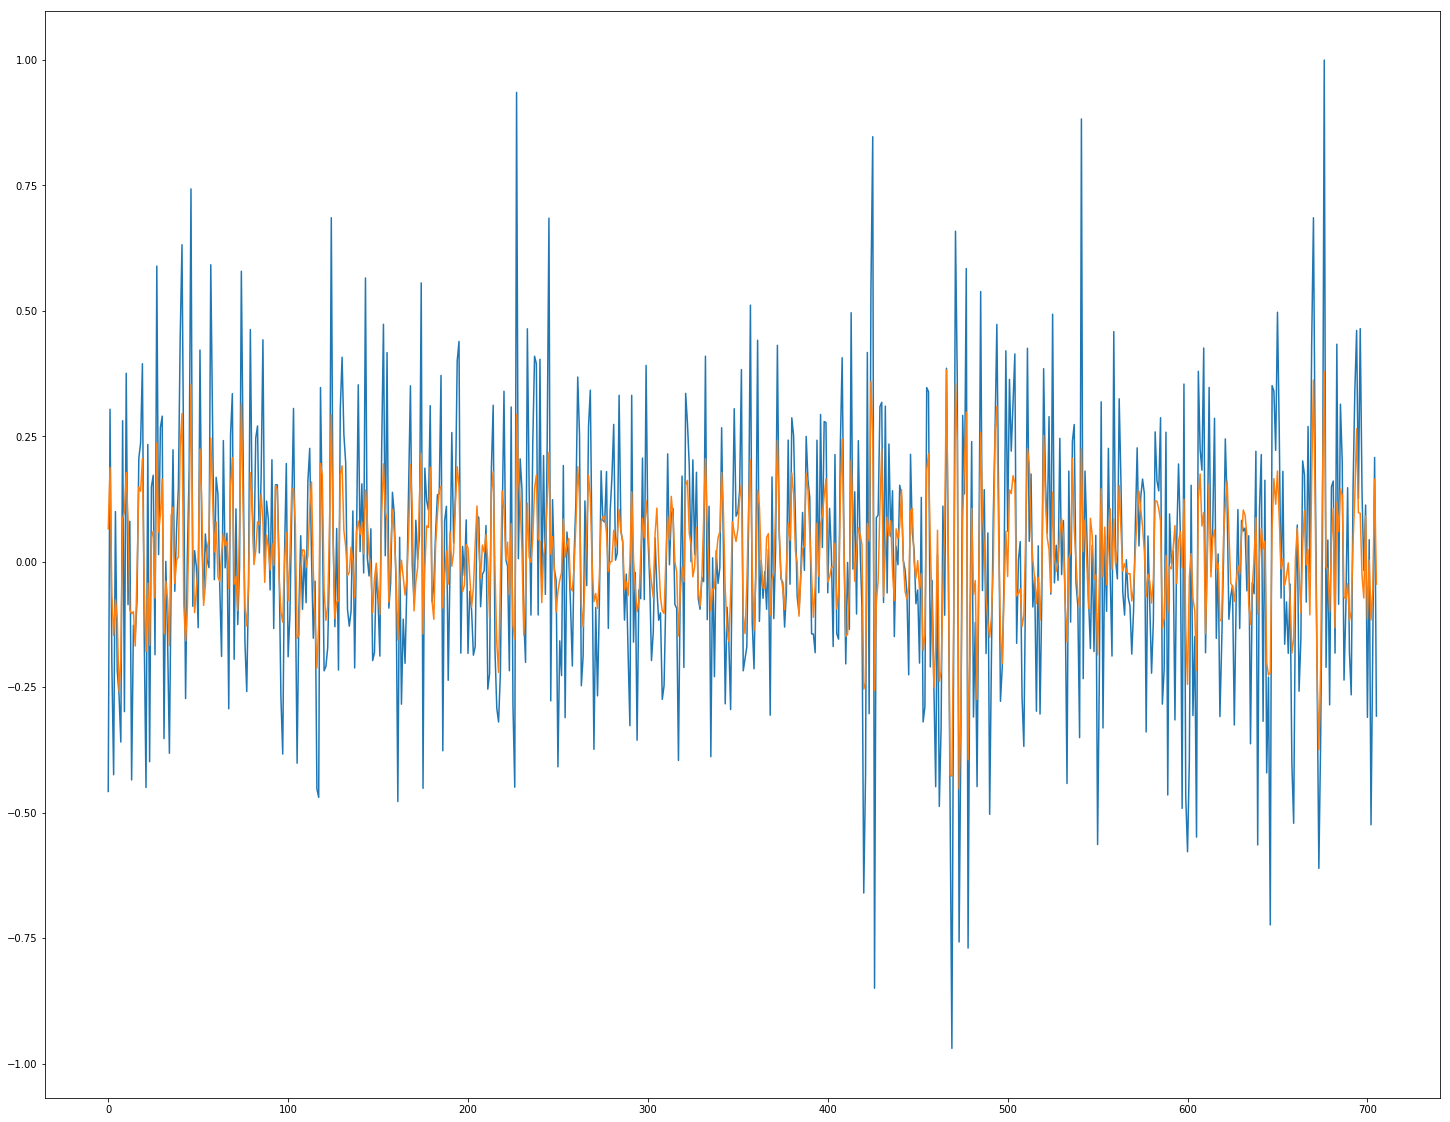

In [60]:
plt.clf()
plt.figure(figsize=(25,20))
plt.plot(timeSeries_original)
plt.plot(timeSeries_reconstructed)
plt.show()

In [63]:
trainData=pd.concat([timeSeries_original,timeSeries_reconstructed], axis=1)
#dumData=[test_timeSeries, dec_test_timeSeries]
#dumData
#print dumData[0]
#np.matrix(dumData)
#Origin_Decod=pd.DataFrame(dumData,columns=['col1,col2'])
#Origin_Decod
trainData.columns = ['original', 'decoded']
trainData.corr()

,original,decoded
original,1.000000,0.838824
decoded,0.838824,1.000000


In [66]:
trainData=pd.concat([timeSeries_original,timeSeries_reconstructed], axis=1)
#dumData=[test_timeSeries, dec_test_timeSeries]
#dumData
#print dumData[0]
#np.matrix(dumData)
#Origin_Decod=pd.DataFrame(dumData,columns=['col1,col2'])
#Origin_Decod
trainData.columns = ['original', 'decoded']
trainData.corr()

,original,decoded
original,1.000000,0.838824
decoded,0.838824,1.000000


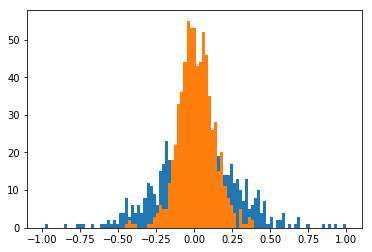

In [67]:
plt.clf()
plt.hist(timeSeries_original,sbins)
plt.hist(timeSeries_reconstructed,sbins)
plt.show()